In [113]:
import pandas as pd
import numpy as np
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d
import warnings

import matplotlib.pyplot as plt


In [114]:
well_excel_path = 'data/18well.xlsx'

In [115]:
df = pd.read_excel('data/18well.xlsx')


In [116]:
# Глобальные настройки сглаживания
SMOOTHING_WINDOW = 51  # Размер окна сглаживания (нечетное число)
SMOOTHING_POLYORDER = 3  # Порядок полинома для фильтра Савицкого-Голея
SMOOTHING_INTERP_METHOD = 'cubic'  # Метод интерполяции для сглаженной кривой
MIN_POINTS_FOR_SMOOTHING = 5  # Минимальное количество точек для сглаживания

In [117]:
def smooth_pressure_timeseries(df):
    """
    Создает сглаженную кривую для временного ряда давления.
    Сглаживание применяется только к существующим данным, но значения
    сглаженной кривой вычисляются для всех дат.
    
    Параметры:
    -----------
    df : pandas.DataFrame
        Датафрейм с колонками 'date' (строки в формате ДД.ММ.ГГГГ) и 'pressure_fact'
    
    Возвращает:
    -----------
    pandas.DataFrame
        Исходный датафрейм с добавленной колонкой 'pressure_smoothed'
    """
    # Создаем копию датафрейма
    df_result = df.copy()
    
    # Преобразуем даты в datetime
    df_result['date_dt'] = pd.to_datetime(df_result['date'], format='%d.%m.%Y')
    
    # Сортируем по дате
    df_result = df_result.sort_values('date_dt').reset_index(drop=True)
    
    # Шаг 1: Получаем только фактические данные (без NaN)
    fact_mask = df_result['pressure_fact'].notna()
    fact_dates = df_result.loc[fact_mask, 'date_dt']
    fact_pressures = df_result.loc[fact_mask, 'pressure_fact'].values
    
    # Проверяем, достаточно ли точек для сглаживания
    if len(fact_pressures) < MIN_POINTS_FOR_SMOOTHING:
        warnings.warn(f"Недостаточно точек для сглаживания. Доступно: {len(fact_pressures)}, требуется: {MIN_POINTS_FOR_SMOOTHING}")
        # Если точек недостаточно, используем простую линейную интерполяцию
        df_result['pressure_smoothed'] = np.nan
        # Интерполируем только между фактическими точками
        if len(fact_pressures) >= 2:
            # Создаем временную шкалу в днях от первой даты
            all_dates_numeric = (df_result['date_dt'] - df_result['date_dt'].min()).dt.days.values
            fact_dates_numeric = (fact_dates - df_result['date_dt'].min()).dt.days.values
            
            # Линейная интерполяция
            interp_func = interp1d(fact_dates_numeric, fact_pressures, 
                                  kind='linear', bounds_error=False, 
                                  fill_value='extrapolate')
            
            # Получаем значения для всех дат
            smoothed_all = interp_func(all_dates_numeric)
            df_result['pressure_smoothed'] = smoothed_all
        
        df_result.drop(columns=['date_dt'], inplace=True)
        return df_result
    
    # Шаг 2: Создаем числовую временную шкалу для фактических точек
    # Используем дни от первой фактической даты
    first_fact_date = fact_dates.iloc[0]
    fact_dates_numeric = (fact_dates - first_fact_date).dt.days.values
    
    # Шаг 3: Создаем равномерную временную шкалу для сглаживания
    # (фильтр Савицкого-Голея требует равномерной сетки)
    min_date_num = fact_dates_numeric.min()
    max_date_num = fact_dates_numeric.max()
    
    # Создаем равномерную сетку с шагом 1 день
    uniform_dates_num = np.arange(min_date_num, max_date_num + 1)
    
    # Интерполируем фактические данные на равномерную сетку
    # (только для целей сглаживания)
    interp_func_uniform = interp1d(fact_dates_numeric, fact_pressures, 
                                  kind=SMOOTHING_INTERP_METHOD, 
                                  bounds_error=False, 
                                  fill_value='extrapolate')
    
    pressures_uniform = interp_func_uniform(uniform_dates_num)
    
    # Шаг 4: Применяем фильтр Савицкого-Голея к равномерной сетке
    # Настраиваем размер окна
    window_length = min(SMOOTHING_WINDOW, len(pressures_uniform))
    if window_length % 2 == 0:
        window_length -= 1  # Делаем нечетным
        if window_length < 3:
            window_length = 3
    
    # Убедимся, что порядок полинома меньше размера окна
    polyorder = min(SMOOTHING_POLYORDER, window_length - 1)
    
    try:
        smoothed_uniform = savgol_filter(pressures_uniform, 
                                        window_length=window_length,
                                        polyorder=polyorder,
                                        mode='interp')
    except Exception as e:
        warnings.warn(f"Ошибка при сглаживании: {str(e)}. Использую интерполированные значения.")
        smoothed_uniform = pressures_uniform
    
    # Шаг 5: Создаем интерполяционную функцию для сглаженной кривой
    # (снова используем фактическую временную шкалу)
    # Создаем функцию, которая интерполирует сглаженные значения
    # на основе равномерной сетки
    interp_smoothed = interp1d(uniform_dates_num, smoothed_uniform,
                              kind=SMOOTHING_INTERP_METHOD,
                              bounds_error=False,
                              fill_value='extrapolate')
    
    # Шаг 6: Вычисляем сглаженные значения для всех дат (включая пропуски)
    all_dates_numeric = (df_result['date_dt'] - first_fact_date).dt.days.values
    smoothed_all = interp_smoothed(all_dates_numeric)
    
    # Ограничиваем значения разумными пределами
    min_pressure = max(0, np.nanmin(fact_pressures) * 0.5)
    max_pressure = np.nanmax(fact_pressures) * 1.5
    smoothed_all = np.clip(smoothed_all, min_pressure, max_pressure)
    
    df_result['pressure_smoothed'] = smoothed_all
    
    # Шаг 7: Убедимся, что сглаженная кривая не имеет NaN
    # (интерполяция с fill_value='extrapolate' должна это обеспечить)
    if df_result['pressure_smoothed'].isna().any():
        # Заполняем оставшиеся NaN линейной интерполяцией
        df_result['pressure_smoothed'] = df_result['pressure_smoothed'].interpolate(
            method='linear', limit_direction='both'
        )
    
    # Удаляем вспомогательные колонки
    df_result.drop(columns=['date_dt'], inplace=True)
    
    return df_result

In [118]:
smoothed_df = smooth_pressure_timeseries(df)

In [119]:
smoothed_df

,date,pressure_fact,pressure_smoothed
0,11.01.2005,86.8000,87.119052
1,12.01.2005,NaN,87.165231
2,19.01.2005,NaN,86.788705
3,20.01.2005,86.8000,86.648587
4,21.01.2005,NaN,86.490297
...,...,...,...
3048,11.03.2025,74.2344,74.448930
3049,12.03.2025,NaN,74.386106
3050,13.03.2025,NaN,74.330345
3051,15.03.2025,74.2344,74.240182


In [120]:
# Функция для визуализации
def plot_comparison(df):
    """
    Визуализация исходных данных и сглаженной кривой.
    """
    
    plt.figure(figsize=(15, 8))
    
    # Исходные данные (фактические точки)
    plt.scatter(df.index, df['pressure_fact'], alpha=0.6, 
                label='Фактические данные', color='blue', s=20)
    
    # Сглаженная кривая
    if 'pressure_smoothed' in df.columns:
        plt.plot(df.index, df['pressure_smoothed'], '-', linewidth=2,
                label='Сглаженная кривая', color='red')
    
    # Подсветка пропущенных точек
    missing_mask = df['pressure_fact'].isna()
    if missing_mask.any():
        plt.scatter(df.index[missing_mask], df['pressure_smoothed'][missing_mask], 
                   alpha=0.4, s=10, color='orange', label='Сглаженные значения (пропуски факта)')
    
    plt.xlabel('Индекс записи')
    plt.ylabel('Давление')
    plt.title('Сравнение фактических данных и сглаженной кривой')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

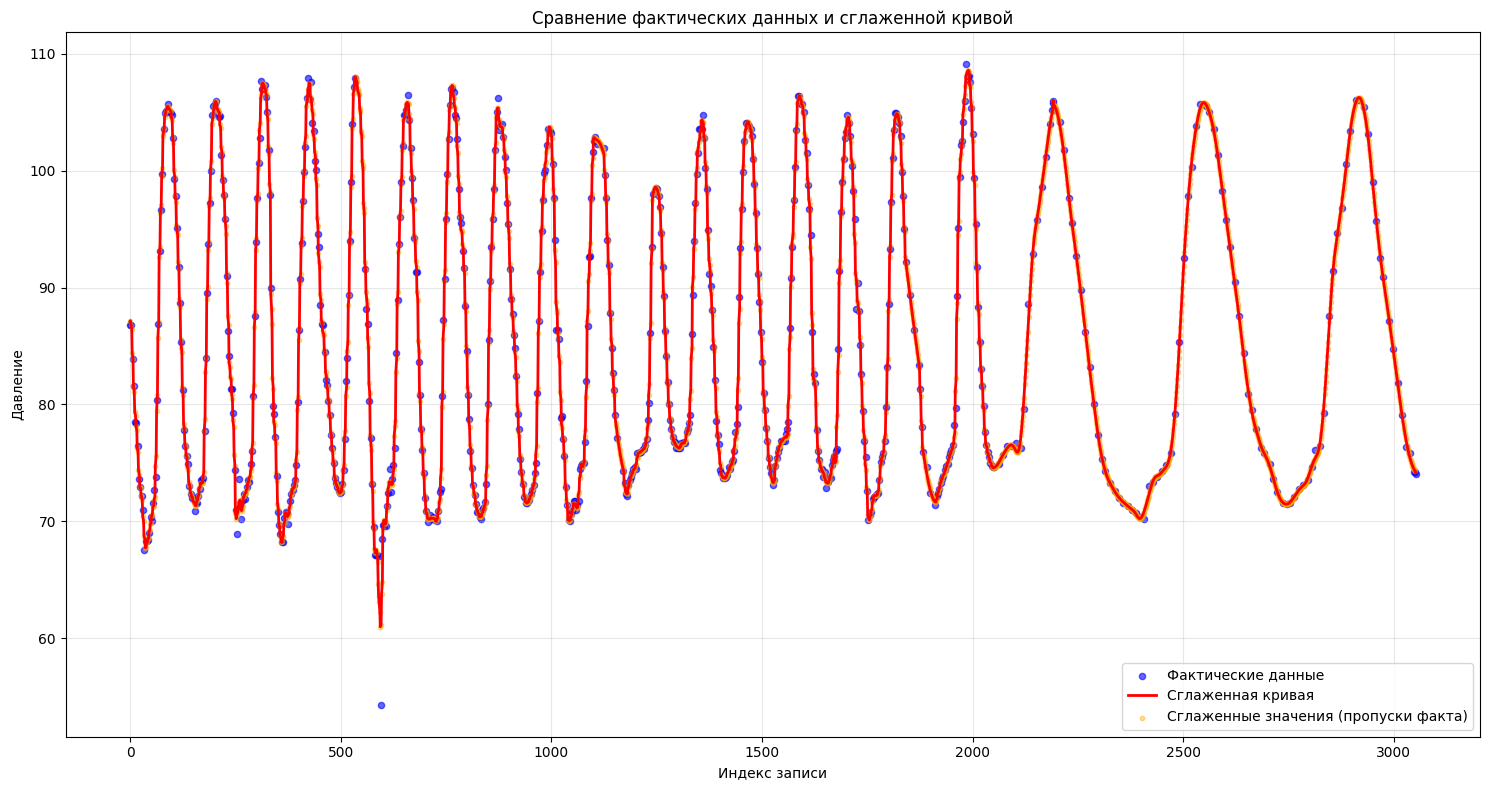

In [121]:
plot_comparison(smoothed_df)

In [122]:
def quick_copy(df, message=None):
    """
    Быстрое копирование датафрейма в буфер обмена.
    
    Параметры:
    -----------
    df : pandas.DataFrame
        Датафрейм для копирования
    message : str, optional
        Дополнительное сообщение для вывода
    """
    try:
        # Используем встроенный метод pandas
        df.to_clipboard(index=False, sep=";", excel=True)
        
        if message:
            print(f"✓ {message}")
        else:
            print(f"✓ Данные скопированы в буфер обмена")
            print(f"  Структура: {len(df)} строк × {len(df.columns)} колонок")
        
        # Показываем превью данных
        print("\nПревью данных:")
        print(df.head(3).to_string())
        print("...")
        
        return True
    except Exception as e:
        print(f"✗ Ошибка: {str(e)}")


In [123]:
quick_copy(smoothed_df)

✓ Данные скопированы в буфер обмена
  Структура: 3053 строк × 3 колонок

Превью данных:
         date  pressure_fact  pressure_smoothed
0  11.01.2005           86.8          87.119052
1  12.01.2005            NaN          87.165231
2  19.01.2005            NaN          86.788705
...


True